# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Задачи проекта

1. Загрузить и подготовить данные.
2. Обучить и проверить модель для каждого региона:
- Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
- Обучить модель и сделать предсказания на валидационной выборке.
- Сохранить предсказания и правильные ответы на валидационной выборке.
- Напечатать на экране средний запас предсказанного сырья и RMSE модели.
- Проанализировать результаты.
3. Расчет прибылт:
- Все ключевые значения для расчётов сохранить в отдельных переменных.
- Рассчитайть достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе. 
- Напишсать выводы по этапу подготовки расчёта прибыли.
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- Выберать скважины с максимальными значениями предсказаний. 
- Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитать прибыль для полученного объёма сырья.
5. Расчет рисков и прибыли для каждого региона:
- Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков.
- Написать выводы: предложить регион для разработки скважин и обосновать выбор.

# Описание данных

- id — уникальный идентификатор скважины;

- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

- product — объём запасов в скважине (тыс. баррелей).

## Импорты

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
RANDOM_STATE=12345

## Загрузка и подготовка данных

In [2]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
display(df1)
display(df2)
df3

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


In [4]:
display(df1.info())
display(df2.info())
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
display(df1.describe())
display(df2.describe())
df3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [6]:
print(df1.duplicated().sum())
print()
print(df2.duplicated().sum())
print()
print(df3.duplicated().sum())

0

0

0


In [7]:
df1 = df1.drop('id', axis=1)#удаляем столбец id из данных
df2 = df2.drop('id', axis=1)
df3 = df3.drop('id', axis=1)

In [8]:
def num_plots(df,about):#функция для построения графиков по количественным признакам 
    fig,axes = plt.subplots(1, 2,figsize = (15,5))
    plt.subplot(1,2,1)
    a = df.count()
    b = round(1 + 3.322*math.log(a)) #для определения оптимального количества интервалов используется правило Стёрджеса
    plt.hist(df,bins = b,ec='black')
    plt.xlabel('Значения')
    plt.ylabel("Частота")
    plt.title('Распределение значений по признаку {0}'.format(about)),
    plt.subplot(1,2,2)
    plt.boxplot(df, vert=False)
    plt.title('Ящик с усами для признака {0}'.format(about))
    plt.show();

Первый регион


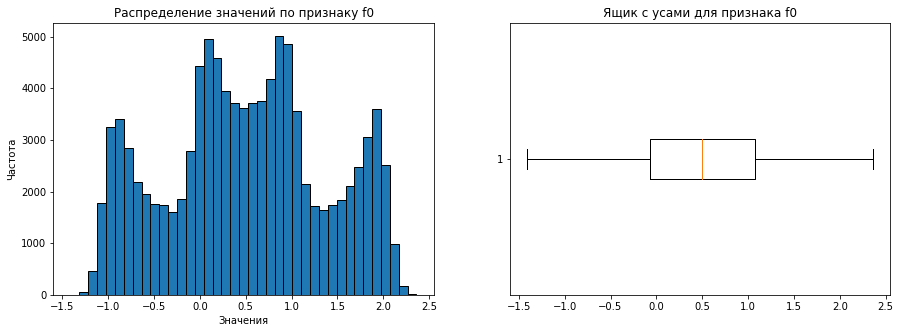

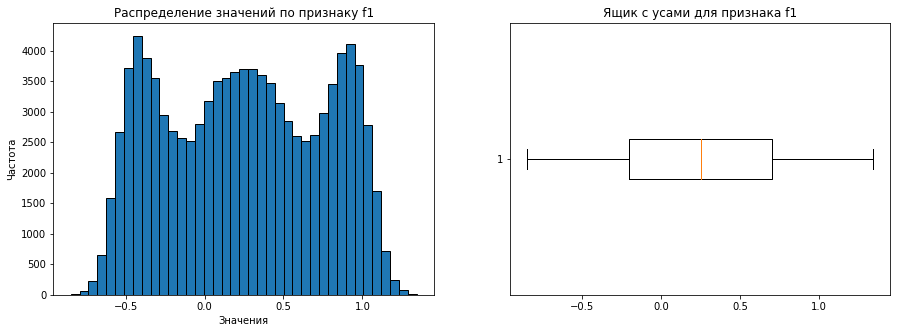

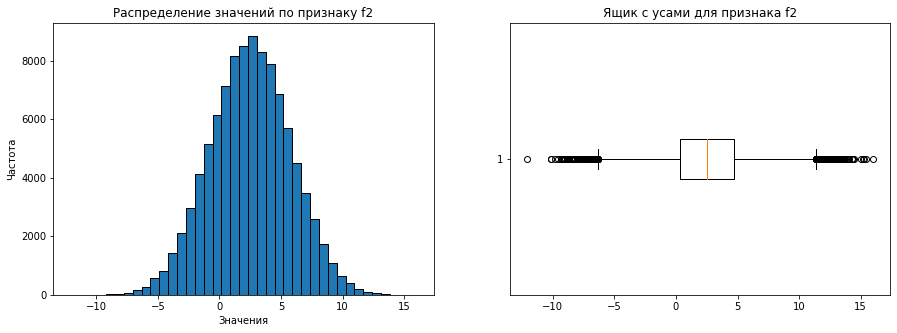

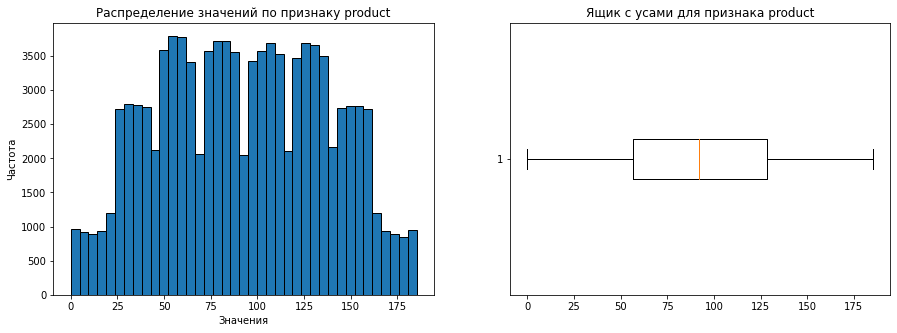

Второй регион


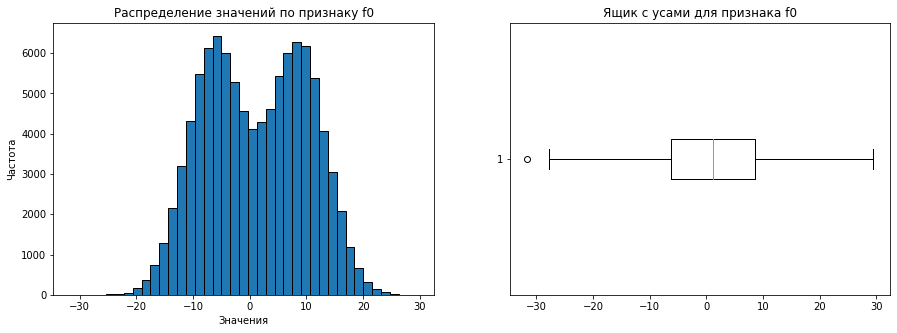

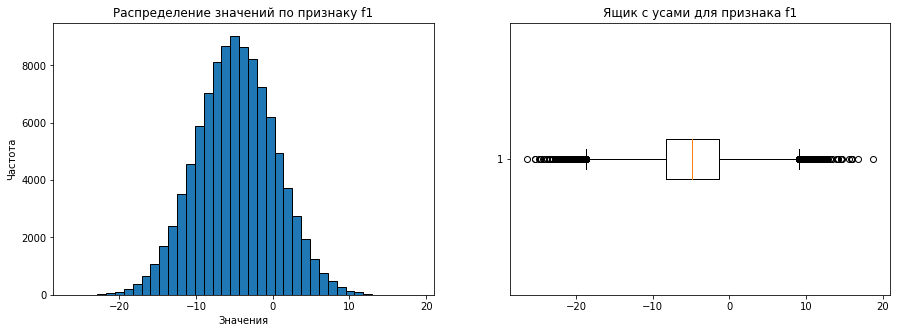

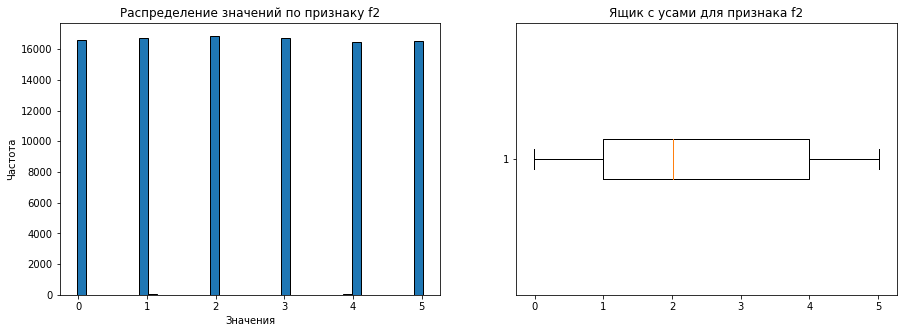

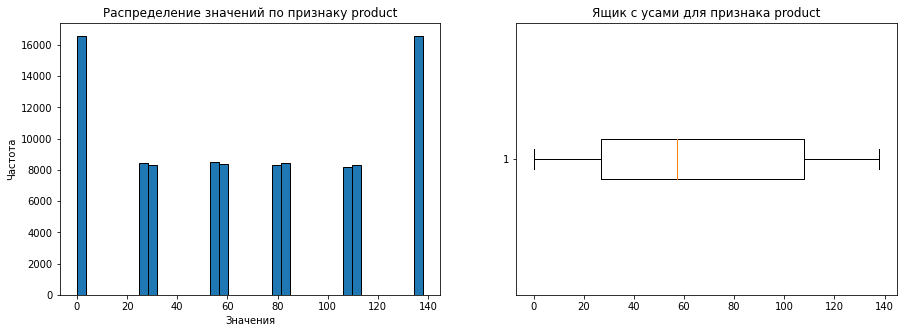

Третий регион


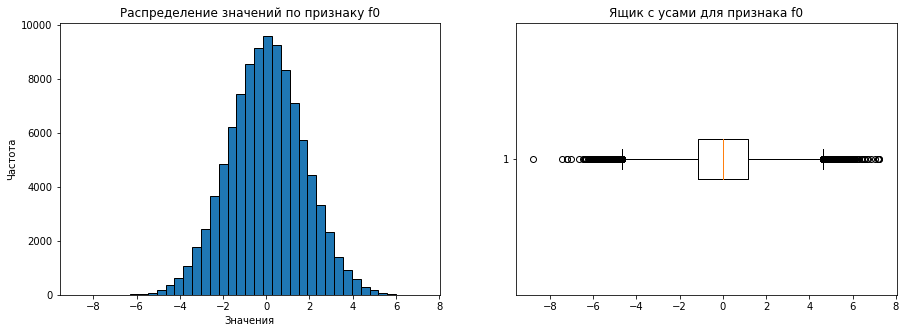

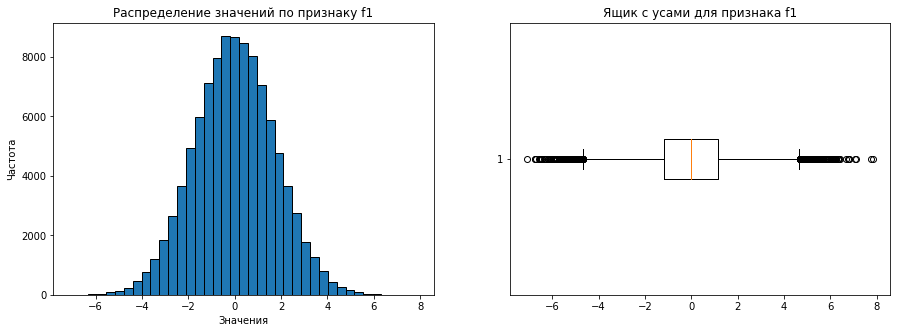

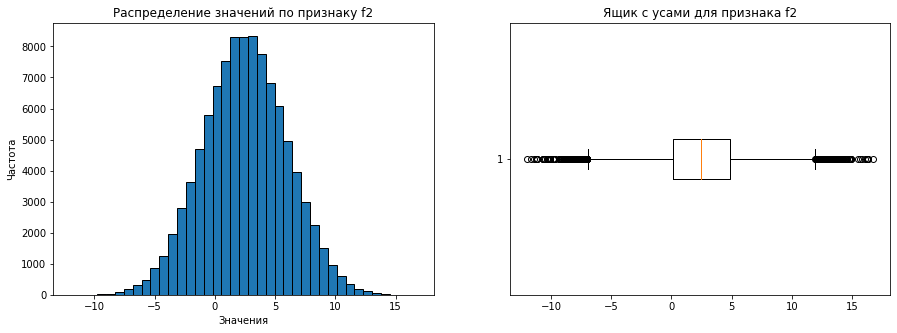

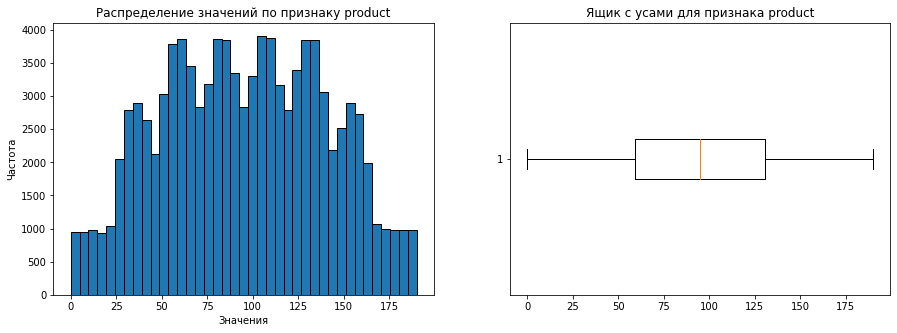

In [9]:
datas = [df1,df2,df3]
region_names = ['Первый регион', 'Второй регион', 'Третий регион']
for d, region_name in zip(datas, region_names):
    print(region_name) 
    for_num = d[d.select_dtypes(include='number').columns]
    for x in for_num:
        num_plots(d[x],x)
        plt.show()

# Вывод

По результатам первичного анализа можно сказать, что в данных нет пропусков, также в данных отустсвуют дубликаты, все типы данных соотвуетсвующие, нулевых значений/аномалий также нет

Распределения в данных сильно отличаются, например во втором регионе F2 и product имеют мультимодальное распредление.

Нормальное распределение характерно только для:
- f2 в 1 регионе, 
- f1 во 2 регионе
- f0, f1, f2 в 3 регионе.

## Обучение и проверка модели

In [10]:
target1=df1['product']
features1=df1.drop(['product'], axis=1)

target2=df2['product']
features2=df2.drop(['product'], axis=1)

target3=df3['product']
features3=df3.drop(['product'], axis=1)

In [11]:
# Разобьём данные на обучающую и валидационную выборки в соотношении 75:25:    
features1_train, features1_valid, target1_train, target1_valid = \
    train_test_split(features1, target1, test_size=0.25, random_state=RANDOM_STATE)

In [12]:
# Разобьём данные на обучающую и валидационную выборки в соотношении 75:25:    
features2_train, features2_valid, target2_train, target2_valid = \
    train_test_split(features2, target2, test_size=0.25, random_state=RANDOM_STATE)

In [13]:
# Разобьём данные на обучающую и валидационную выборки в соотношении 75:25:    
features3_train, features3_valid, target3_train, target3_valid = \
    train_test_split(features3, target3, test_size=0.25, random_state=RANDOM_STATE)

In [14]:
model1=LinearRegression() #интегрируем модель
model1.fit(features1_train,target1_train) #обучаем ее
predict1=model1.predict(features1_valid) #получаем предсказания на валидационной выборке
rmse1 = mean_squared_error(target1_valid, predict1)**0.5 #квадрат из MSE 
print('RMSE: %.2f'% rmse1)

RMSE: 37.58


In [15]:
model2=LinearRegression()
model2.fit(features2_train,target2_train)
predict2=model2.predict(features2_valid)
rmse2 = mean_squared_error(target2_valid, predict2)**0.5
print('RMSE: %.2f'% rmse2)

RMSE: 0.89


In [16]:
model3=LinearRegression()
model3.fit(features3_train,target3_train)
predict3=model3.predict(features3_valid)
rmse3 = mean_squared_error(target3_valid, predict3)**0.5
print('RMSE: %.2f'% rmse3)

RMSE: 40.03


In [17]:
regions = pd.DataFrame(index=['Средний запас предсказанного сырья','RMSE'], columns=['регион 1','регион 2','регион 3'])
regions['регион 1'] = predict1.mean(), rmse1
regions['регион 2'] = predict2.mean(), rmse2
regions['регион 3'] = predict3.mean(), rmse3
regions

,регион 1,регион 2,регион 3
Средний запас предсказанного сырья,92.592568,68.728547,94.965046
RMSE,37.579422,0.893099,40.029709


# Вывод
- Разделили данные на валидационную и трейн выборку в соотношении 75/25 

- Обучили модель LinearRegression

- Получили предсказания на валидационной выборке 

- Создали таблицу с визуализацией среднего запаса сырья по регионам и метрикой RMSE, наименьшее значение у 2 региона, наибольшее у 3 региона



## Подготовка к расчёту прибыли

In [18]:
budget= 10000000 #Бюджет в тыс руб
cost = 450 #цена 1 ед в тыс руб
for_1_point = budget/200

In [19]:
print('Средний запас сырья в первом регионе:', round(df1['product'].mean(),2))
print('Средний запас сырья во втором регионе:', round(df2['product'].mean(),2))
print('Средний запас сырья в третьем регионе:', round(df3['product'].mean(),2))
print('Бюджет на 1 точку:', for_1_point, 'тыс рублей')
print('Достаточный обьем сырья в 1 скважине для безубыточной дятельности:',round(for_1_point/cost,2),'тыс баррелей')
print('Общий объем сырья на регион для безубытчной дяетельности:',round(for_1_point/cost,3)*200,'тыс баррелей')

Средний запас сырья в первом регионе: 92.5
Средний запас сырья во втором регионе: 68.83
Средний запас сырья в третьем регионе: 95.0
Бюджет на 1 точку: 50000.0 тыс рублей
Достаточный обьем сырья в 1 скважине для безубыточной дятельности: 111.11 тыс баррелей
Общий объем сырья на регион для безубытчной дяетельности: 22222.2 тыс баррелей


In [20]:
for df in datas: #посчитаем прибыль с 1 скважины в регионах
    df['profit'] = df['product']*cost
    display(df.head(2))

,f0,f1,f2,product,profit
0,0.705745,-0.497823,1.22117,105.280062,47376.027830
1,1.334711,-0.340164,4.36508,73.037750,32866.987619


,f0,f1,f2,product,profit
0,-15.001348,-8.276000,-0.005876,3.179103,1430.596162
1,14.272088,-3.475083,0.999183,26.953261,12128.967464


,f0,f1,f2,product,profit
0,-1.146987,0.963328,-0.828965,27.758673,12491.402954
1,0.262778,0.269839,-2.530187,56.069697,25231.363485


In [21]:
diff = pd.DataFrame(index=['Средний запас предсказанного сырья','RMSE','Разница между необходимым и предсказанным сырьем', 'Разница в %'], columns=['регион 1','регион 2','регион 3'])
diff['регион 1'] = predict1.mean(), rmse1, predict1.mean()-round(for_1_point/cost,2), (predict1.mean()/round(for_1_point/cost,2)-1)*100
diff['регион 2'] = predict2.mean(), rmse2, predict2.mean()-round(for_1_point/cost,2), (predict2.mean()/round(for_1_point/cost,2)-1)*100
diff['регион 3'] = predict3.mean(), rmse3, predict3.mean()-round(for_1_point/cost,2), (predict3.mean()/round(for_1_point/cost,2)-1)*100
diff

,регион 1,регион 2,регион 3
Средний запас предсказанного сырья,92.592568,68.728547,94.965046
RMSE,37.579422,0.893099,40.029709
Разница между необходимым и предсказанным сырьем,-18.517432,-42.381453,-16.144954
Разница в %,-16.665856,-38.143689,-14.530604


Как видим ни в 1 регионе средних запасов сырья не хватает даже для окупаемости деятельности, значит необходимо искать самые богатые на сырьё скважины

In [22]:
def select(name): #функция для расчета прибыли
    reg = pd.Series(name).sort_values(ascending=False).head(200)
    reserve = reg.sum()
    profit = round((reserve * cost - budget)/1000000,3)
    print('Прибыль с региона составляет:', profit,'млрд рублей')

Для региона 1 

In [23]:
select(predict1)

Прибыль с региона составляет: 3.996 млрд рублей


Для региона 2

In [24]:
select(predict2)

Прибыль с региона составляет: 2.486 млрд рублей


Для региона 3

In [25]:
select(predict3)

Прибыль с региона составляет: 3.322 млрд рублей


# Вывод
Минимальное количество баррелей в скважине должно быть не менее 111 тыс., иначе деятельность будет убыточной 

Наибольшая прибыль будет с 1-го региона, наименьшая со 2-го, однако это не значит, что мы выберем 1 регион, тк почти во всех сферах чем выше прибыль, тем выше риски. Необходимо расчитать риски убытков для каждого региона.

## Расчёт прибыли и рисков 

In [26]:
def profit(predict,target):
    reg = pd.Series(predict).sort_values(ascending=False)
    reserve = target[reg.index].head(200).sum()
    profit = reserve * cost - budget
    return profit

In [27]:
def revenue(target,predict):
    values = []
    predict = pd.Series(predict, index=target.index)
    state = np.random.RandomState(12345)
    
    for i in range(1000):
        target_subsample = target.sample(n=500,replace=True, random_state=state)
        probs_subsample = predict[target_subsample.index]
        values.append(profit(probs_subsample,target_subsample))  
    values = pd.Series(values)
    mean = values.mean()
    risks = round((values< 0).mean()*100, 1)
    lower = values.quantile(0.025)
    higher = values.quantile(0.975)
    
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(10,8))
    plt.xlabel('Прибыль')
    plt.ylabel('Количество')
    plt.show()
    
    print('Средняя прибыль: ',round(values.mean(),2),'тыс.руб')
    print(f'95%-ый доверительный интервал: от {lower} тыс.руб до {higher} тыс.руб')
    print('Вероятность убытка: {:.1%}'.format(risks/100))

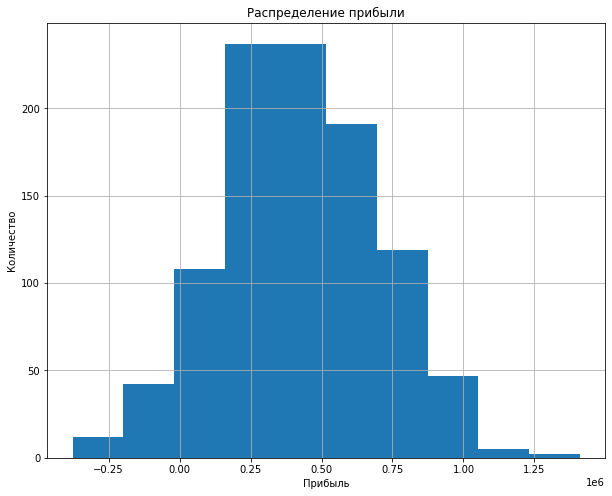

Средняя прибыль:  425938.53 тыс.руб
95%-ый доверительный интервал: от -102090.09483793723 тыс.руб до 947976.353358369 тыс.руб
Вероятность убытка: 6.0%


In [28]:
revenue(target1_valid,predict1)

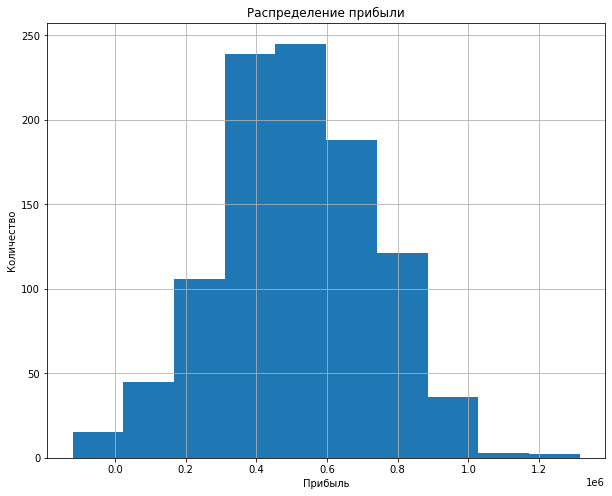

Средняя прибыль:  515222.77 тыс.руб
95%-ый доверительный интервал: от 68873.22537050233 тыс.руб до 931547.5912570491 тыс.руб
Вероятность убытка: 1.0%


In [29]:
revenue(target2_valid,predict2)

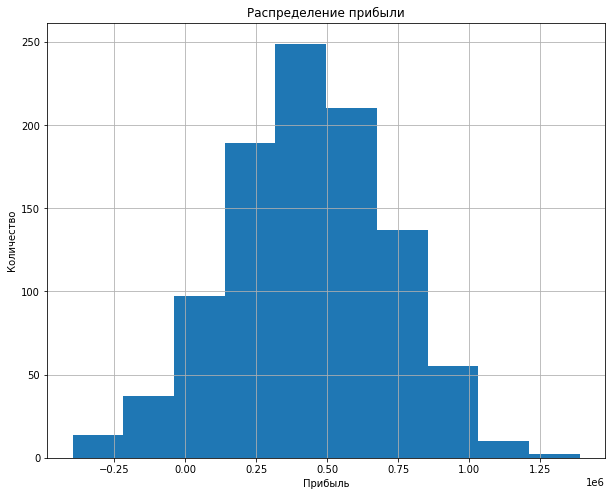

Средняя прибыль:  435008.36 тыс.руб
95%-ый доверительный интервал: от -128880.54732978888 тыс.руб до 969706.9541802666 тыс.руб
Вероятность убытка: 6.4%


In [30]:
revenue(target3_valid,predict3)

# Вывод
Заказчику стоит выбрать второй регион для разработки скважин, это можно обяснить тем, что средняя прибыль в данном регионе наивысшая, а вероятность убытка удовлетворяет требованиям заказчика, а также является наименьшей среди 3 представленных регионов, а также тем, что доверительный интервал лишь 2-го региона не содержит отрицательных значений

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован

# Общий вывод
Мы провелли исследование 3 регионов. Нами было обучено 3 модели линейной регрессии и на их основе получены пресдказания содержания сырья в скважинах. Изначально мы обнаружили, что среднего запаса сырья во всех регионах не хватает даже для безубыточной деятельности, однако позже выяснили, что если использовать только скважины с наибольшим содержанием в них сырья, то средний доход со 2-го региона составит 515 млн рублей, а риски убытков в этом регионе будут наименьшими, по сравнению с остальными регионами.